In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-02-01 10:56:28,963: Default instance: ibm-q/open/main


/opt/conda/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


          ┌───┐┌───────┐ ░ ┌─┐                  
u_qreg_0: ┤ H ├┤0      ├─░─┤M├──────────────────
          ├───┤│       │ ░ └╥┘┌─┐               
u_qreg_1: ┤ H ├┤1      ├─░──╫─┤M├───────────────
          ├───┤│  iqft │ ░  ║ └╥┘┌─┐            
u_qreg_2: ┤ H ├┤2      ├─░──╫──╫─┤M├────────────
          ├───┤│       │ ░  ║  ║ └╥┘┌─┐         
u_qreg_3: ┤ H ├┤3      ├─░──╫──╫──╫─┤M├─────────
          └───┘└───────┘ ░  ║  ║  ║ └╥┘┌─┐      
b_qreg_0: ───────────────░──╫──╫──╫──╫─┤M├──────
                         ░  ║  ║  ║  ║ └╥┘┌─┐   
b_qreg_1: ───────────────░──╫──╫──╫──╫──╫─┤M├───
                         ░  ║  ║  ║  ║  ║ └╥┘┌─┐
b_qreg_2: ───────────────░──╫──╫──╫──╫──╫──╫─┤M├
                         ░  ║  ║  ║  ║  ║  ║ └╥┘
  meas: 7/══════════════════╩══╩══╩══╩══╩══╩══╩═
                            0  1  2  3  4  5  6 
{'0000000': 1024}


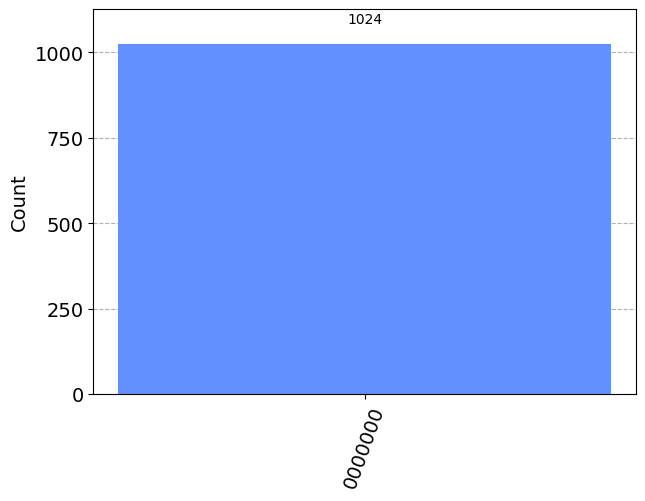

In [31]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from qiskit.circuit.library import QFT
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

def initialize_circuit(t):
    """
    Initialize the qubits according to |ϕ0>.
    
    Parameters:
        t (int): Number of qubits for initialization.
    
    Returns:
        QuantumCircuit: Quantum circuit for initialization.
    """
    qc = QuantumCircuit(t)
    for qubit in range(t):
        qc.initialize([1, 0], qubit)  # Initialize qubit to |0>
    return qc

def construct_V_gate(upper_register, bottom_register, ancilla, N):
    """
    Construct the gate V for modular exponentiation.
    
    Parameters:
        upper_register (QuantumRegister): Quantum register for the upper qubits.
        bottom_register (QuantumRegister): Quantum register for the bottom qubits.
        ancilla (QuantumRegister): Ancilla qubit.
        N (int): Number to be factored.
    
    Returns:
        QuantumCircuit: Quantum circuit for the V gate.
    """
    qc = QuantumCircuit(upper_register, bottom_register, ancilla)
    
    # Create classical register for conditional operations
    classical_reg = ClassicalRegister(bottom_register.size, name='creg')
    qc.add_register(classical_reg)
    
    # Apply conditional x gates based on the values in bottom_register
    for i in range(upper_register.size):
        shift_count = abs(upper_register.size - i - 1)  # Ensure shift count is non-negative
        qc.x(upper_register[i]).c_if(classical_reg, 1 << shift_count)
    
    return qc



def mod_exp_gate(qc, upper_register, ancilla, l, N):
    """
    Apply controlled modular exponentiation gate to the quantum circuit.

    Parameters:
        qc (QuantumCircuit): Quantum circuit.
        upper_register (QuantumRegister): Quantum register for the upper qubits.
        ancilla (QuantumRegister): Ancilla qubit.
        l (int): Exponent value for modular exponentiation.
        N (int): Number to be factored.
    """
    n = upper_register.size  # Number of qubits in the upper register
    
    # Create classical register and classical bits for ancilla qubit
    creg = ClassicalRegister(1, name='creg')
    qc.add_register(creg)
    
    # Apply controlled modular exponentiation gate
    for i in range(n):
        exponent = 2 ** (n - i - 1) * l  # Calculate the exponent for the controlled gate
        qc.cx(upper_register[i], ancilla)  # Control the ancilla qubit with the upper qubits
        qc.x(ancilla).c_if(creg, exponent % N)  # Conditionally apply X gate based on the exponent
        qc.cx(upper_register[i], ancilla)  # Uncompute the ancilla qubit


def modular_exponentiation(qc, upper_register, N):
    """
    Apply modular exponentiation gate to the upper register.
    
    Parameters:
        qc (QuantumCircuit): Main quantum circuit.
        upper_register (QuantumRegister): Quantum register for the upper qubits.
        N (int): Number to be factored.
    """
    qc = QuantumCircuit(5)
    upper_register = QuantumRegister(4, name='upper')
    ancilla = QuantumRegister(1, name='ancilla')
    qc.add_register(upper_register)
    qc.add_register(ancilla)
    mod_exp_gate(qc, upper_register, ancilla, 3, 15)  # Apply mod_exp_gate with l=3 and N=15


        
# Define the function to create the quantum circuit for Shor's algorithm
def shors_algorithm(N):
    #-------Initialization-------#
    # Step 1: Initialization
    t = 3  # log(N) upper limit
    upper_register = QuantumRegister(n_qubits, 'u_qreg')
    bottom_register = QuantumRegister(t, 'b_qreg')
    #ancilla = QuantumRegister(1, 'ancilla')
    #classical_reg = ClassicalRegister(bottom_register.size, name='creg')
    
    qc = QuantumCircuit(upper_register, bottom_register)
        
    #-------Parallelization-------#
    # Step 2: Apply Hadamard gate - 
    qc.h(range(n_qubits))

    #-------Ampl ampl-------#
    """# Step 3: Construct gate V (Modular Exponentiation Gate)
    V_gate_circuit = construct_V_gate(upper_register, bottom_register, ancilla, N)
    qc.append(V_gate_circuit, upper_register[:] + bottom_register[:] + ancilla[:])
    
    # Step 4: Modular Exponentiation (U)
    modular_exponentiation(qc, bottom_register, ancilla, N)"""

    
    # Step 5: Apply Inverse Quantum Fourier Transform (IQFT)
    qft_gate = QFT(num_qubits=n_qubits, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=True, name='iqft')
    qc.append(qft_gate, upper_register)

    #-------Measurement-------#
    # Step 6: Measurement
    qc.measure_all()    
    
    # Step 7: Continued Fraction Algorithm
    # Use continued fraction algorithm to find convergents
    # Code for continued fraction algorithm goes here
    
    # Step 8: Check for Period
    # Check if x^r mod N equals 1
    # Code to check for period goes here
    
    # Step 9: Repeat for Accuracy
    # Repeat steps multiple times for accuracy
    # Code for repetition goes here
    
    return qc        


# Define the number to be factored (for example, N = 15)
N = 143

# Define the number of qubits
n_qubits = 4  # Adjust this value based on the size of N and desired accuracy

# Create the quantum circuit for Shor's algorithm
qc = shors_algorithm(N)

# Visualize the circuit
qc.draw(output='mpl')
print(qc)

# Execute the circuit on a simulator
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1024)
result = job.result()

# Get the counts
counts = result.get_counts(qc)
print(counts)

# Visualize the counts
plot_histogram(counts)

In [57]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT


def mod_exp_gate(qc, upper_register, ancilla, l, N):
    """
    Apply controlled modular exponentiation gate to the quantum circuit.

    Parameters:
        qc (QuantumCircuit): Quantum circuit.
        upper_register (QuantumRegister): Quantum register for the upper qubits.
        ancilla (QuantumRegister): Ancilla qubit.
        l (int): Exponent value for modular exponentiation.
        N (int): Number to be factored.
    """
    n = upper_register.size  # Number of qubits in the upper register
    
    # Create classical register for conditional operations
    classical_reg = ClassicalRegister(n, name='creg2')
    qc.add_register(classical_reg)
    
    # Apply controlled modular exponentiation gate
    for i in range(n):
        exponent = 2 ** (n - i - 1) * l  # Calculate the exponent for the controlled gate
        qc.cx(upper_register[i], ancilla[0])  # Control the ancilla qubit with the upper qubits
        qc.x(ancilla[0]).c_if(classical_reg, 1 << i)  # Conditionally apply X gate based on the exponent
        qc.cx(upper_register[i], ancilla[0])  # Uncompute the ancilla qubit


def modular_exponentiation(qc, upper_register, ancilla, N):
    """
    Apply modular exponentiation gate to the upper register.
    
    Parameters:
        qc (QuantumCircuit): Main quantum circuit.
        upper_register (QuantumRegister): Quantum register for the upper qubits.
        ancilla (QuantumRegister): Ancilla qubit.
        N (int): Number to be factored.
    """
    mod_exp_gate(qc, upper_register, ancilla, 2, N)  # Apply mod_exp_gate with l=2 and N=N

def shors_algorithm(N):
    # Step 1: Initialization
    n = 4  # Number of qubits for the upper register
    t = 3  # Number of qubits for the bottom register
    upper_register = QuantumRegister(n, 'u_qreg')
    bottom_register = QuantumRegister(t, 'b_qreg')
    ancilla = QuantumRegister(1, 'ancilla')
    classical_reg = ClassicalRegister(t, name='creg')
    
    qc = QuantumCircuit(upper_register, bottom_register, ancilla, classical_reg)
        
    # Step 2: Apply Hadamard gate
    qc.h(upper_register[:])

    # Step 3: Construct gate V (Modular Exponentiation Gate)
    """V_gate_circuit = construct_V_gate(upper_register, bottom_register, ancilla, N)
    qc.append(V_gate_circuit, upper_register[:] + bottom_register[:] + ancilla[:])"""
    
    # Step 4: Modular Exponentiation (U)
    modular_exponentiation(qc, upper_register, ancilla, N)

    # Step 5: Apply Inverse Quantum Fourier Transform (IQFT)
    qft_gate = QFT(num_qubits=n, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=True, name='iqft')
    qc.append(qft_gate, upper_register)

    # Step 6: Measurement
    qc.measure(bottom_register, classical_reg)  # Measure the bottom register qubits and store results in the classical register
    return qc

# Test the algorithm
N = 15  # Number to be factored
shor_circuit = shors_algorithm(N)
print(shor_circuit)


          ┌───┐                                                              »
u_qreg_0: ┤ H ├────────■───────────■─────────────────────────────────────────»
          ├───┤        │           │                                         »
u_qreg_1: ┤ H ├────────┼───────────┼────■───────────■────────────────────────»
          ├───┤        │           │    │           │                        »
u_qreg_2: ┤ H ├────────┼───────────┼────┼───────────┼────■───────────■───────»
          ├───┤        │           │    │           │    │           │       »
u_qreg_3: ┤ H ├────────┼───────────┼────┼───────────┼────┼───────────┼────■──»
          └┬─┬┘        │           │    │           │    │           │    │  »
b_qreg_0: ─┤M├─────────┼───────────┼────┼───────────┼────┼───────────┼────┼──»
           └╥┘ ┌─┐     │           │    │           │    │           │    │  »
b_qreg_1: ──╫──┤M├─────┼───────────┼────┼───────────┼────┼───────────┼────┼──»
            ║  └╥┘┌─┐  │           │    │           

          ┌───┐┌──────────────┐┌───────┐┌─┐         
 upper_0: ┤ H ├┤0             ├┤0      ├┤M├─────────
          ├───┤│              ││       │└╥┘┌─┐      
 upper_1: ┤ H ├┤1             ├┤1      ├─╫─┤M├──────
          ├───┤│              ││  IQFT │ ║ └╥┘┌─┐   
 upper_2: ┤ H ├┤2             ├┤2      ├─╫──╫─┤M├───
          ├───┤│              ││       │ ║  ║ └╥┘┌─┐
 upper_3: ┤ H ├┤3             ├┤3      ├─╫──╫──╫─┤M├
          └───┘│              │└───────┘ ║  ║  ║ └╥┘
bottom_0: ─────┤4 circuit-157 ├──────────╫──╫──╫──╫─
               │              │          ║  ║  ║  ║ 
bottom_1: ─────┤5             ├──────────╫──╫──╫──╫─
               │              │          ║  ║  ║  ║ 
bottom_2: ─────┤6             ├──────────╫──╫──╫──╫─
               │              │          ║  ║  ║  ║ 
bottom_3: ─────┤7             ├──────────╫──╫──╫──╫─
               │              │          ║  ║  ║  ║ 
 ancilla: ─────┤8             ├──────────╫──╫──╫──╫─
               └──────────────┘          ║  ║ 

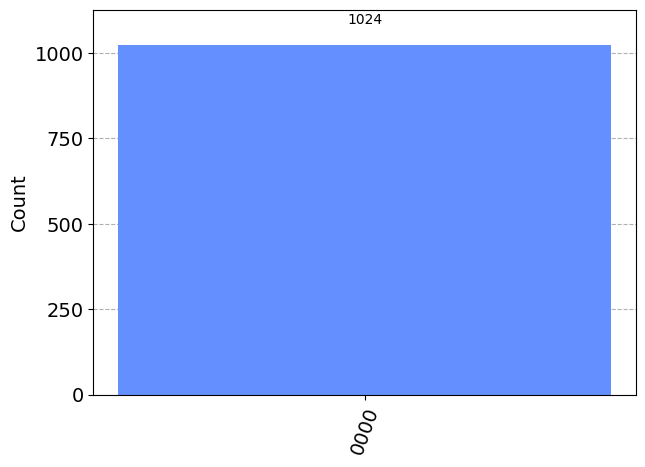

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import pi
from qiskit.circuit.library import QFT

# Function to construct V gate for modular exponentiation
def construct_V_gate(upper_register, bottom_register, ancilla, N):
    """
    Construct the gate V for modular exponentiation.

    Parameters:
        upper_register (QuantumRegister): Quantum register for the upper qubits.
        bottom_register (QuantumRegister): Quantum register for the bottom qubits.
        ancilla (QuantumRegister): Ancilla qubit.
        N (int): Number to be factored.

    Returns:
        QuantumCircuit: Quantum circuit for the V gate.
    """
    qc = QuantumCircuit(upper_register, bottom_register, ancilla)
    
    # Apply controlled modular exponentiation gate
    for i in range(upper_register.size):
        for j in range(bottom_register.size):
            exponent = 2 ** (bottom_register.size - j - 1) * (2 ** i)
            qc.cp(exponent * 2 * pi / N, upper_register[i], bottom_register[j])
    
    return qc

# Example usage
N = 15
t=4 # log_2(N) upper limit
n=t
# Create quantum registers
upper_register = QuantumRegister(n, 'upper')
bottom_register = QuantumRegister(t, 'bottom')
ancilla = QuantumRegister(1, 'ancilla')
classical_reg = ClassicalRegister(n, 'creg')

# Construct quantum circuit
qc = QuantumCircuit(upper_register, bottom_register, ancilla, classical_reg)

# Apply Hadamard gates on upper register
qc.h(upper_register)

# Construct and apply V gate
V_gate = construct_V_gate(upper_register, bottom_register, ancilla, N)
qc.append(V_gate, upper_register[:] + bottom_register[:] + ancilla[:])

# Apply Inverse Quantum Fourier Transform (IQFT)
qc.append(QFT(n, inverse=True), upper_register)

# Measure upper register
qc.measure(upper_register, classical_reg)

print(qc)

# Execute the circuit on a simulator
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1024)
result = job.result()

# Get the counts
counts = result.get_counts(qc)

# Visualize the counts
plot_histogram(counts)


          ┌───┐┌───┐                       ┌─┐                    
 upper_0: ┤ H ├┤ H ├─■────────■────────────┤M├────────────────────
          ├───┤└───┘ │P(π/2)  │       ┌───┐└╥┘         ┌─┐        
 upper_1: ┤ H ├──────■────────┼───────┤ H ├─╫──■───────┤M├────────
          ├───┤               │P(π/2) └───┘ ║  │P(π/2) └╥┘┌───┐┌─┐
 upper_2: ┤ H ├──■──────■─────■─────────────╫──■────────╫─┤ H ├┤M├
          └───┘┌─┴─┐    │                   ║           ║ └───┘└╥┘
bottom_0: ─────┤ X ├────┼───────────────────╫───────────╫───────╫─
               └───┘    │                   ║           ║       ║ 
bottom_1: ──────────────┼───────────────────╫───────────╫───────╫─
                      ┌─┴─┐                 ║           ║       ║ 
bottom_2: ────────────┤ X ├─────────────────╫───────────╫───────╫─
          ┌───┐       └───┘                 ║           ║       ║ 
bottom_3: ┤ X ├─────────────────────────────╫───────────╫───────╫─
          └───┘                             ║           ║     

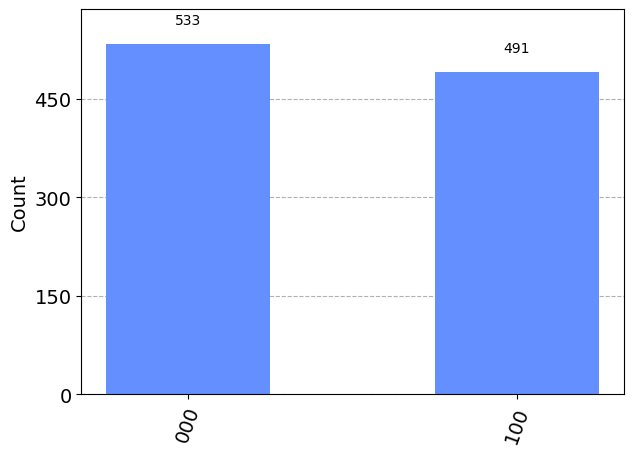

In [11]:
#SHOR ALGORITHM N=15, P=11, x=2, from:  Jiahao Zhao 2022 J. Phys.: Conf. Ser. 2386 012010
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import pi
from qiskit.circuit.library import QFT
import math

# Example usage
N = 15
t=4 # log_2(N) upper limit
n=3
# Create quantum registers
upper_register = QuantumRegister(n, 'upper')
bottom_register = QuantumRegister(t, 'bottom')
classical_reg = ClassicalRegister(n, 'creg')

# Construct quantum circuit
qc = QuantumCircuit(upper_register, bottom_register, classical_reg)

# Apply Hadamard gates on upper register
qc.h(upper_register)
qc.x(bottom_register[3])

# Construct and apply V gate
"""V_gate = construct_V_gate(upper_register, bottom_register, N)
qc.append(V_gate, upper_register[:] + bottom_register[:])"""
qc.cx(upper_register[2], bottom_register[0])
qc.cx(upper_register[2], bottom_register[2])


"""# Apply Inverse Quantum Fourier Transform (IQFT)
qc.append(QFT(n, inverse=True), upper_register)

# Measure upper register
qc.measure(upper_register, classical_reg)"""


angle = math.pi / 2

qc.h(upper_register[0])
qc.cp(angle, upper_register[0],upper_register[1])
qc.cp(angle, upper_register[0],upper_register[2])
qc.h(upper_register[1])

qc.measure(upper_register[0],classical_reg[0])
qc.cp(angle, upper_register[1],upper_register[2])
qc.measure(upper_register[1],classical_reg[1])
qc.h(upper_register[2])
qc.measure(upper_register[2],classical_reg[2])

print(qc)

# Execute the circuit on a simulator
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1024)
result = job.result()

# Get the counts
counts = result.get_counts(qc)

# Visualize the counts
plot_histogram(counts)
